In [ ]:
%pip install geoparse anndata pandas tqdm cell-gears scanpy plotly scipy numpy torch torch_geometric pyro-ppl mlflow harmonypy matplotlib

In [9]:
import GEOparse
import os
import sys
import anndata as ad
import pandas as pd
import gzip
from tqdm import tqdm
from gears.utils import dataverse_download
from gears import PertData
import scanpy as sc
import plotly.express as px
from itertools import combinations
from zipfile import ZipFile
from scipy.sparse import csr_matrix, issparse
import numpy as np
import pickle

from data_processing.data_loader import find_sample_files, select_unique_samples, load_anndata_from_files
from data_processing.anndata_utils import combine_anndatas
from data_processing.preprocessing import run_pca, run_harmony # Add run_combat if you plan to use it
from data_processing.analysis import find_differentially_expressed_genes, find_upregulated_genes_manual

# Define base 

# Download AML scRNA dataset
https://pubmed.ncbi.nlm.nih.gov/30827681/

In [10]:
scRNA_aml = GEOparse.get_GEO(geo="GSE116256")
scrna_dataDir = f"scrna_data"
os.makedirs(scrna_dataDir, exist_ok=True)

28-Apr-2025 04:32:02 DEBUG utils - Directory ./ already exists. Skipping.
28-Apr-2025 04:32:02 INFO GEOparse - File already exist: using local version.
28-Apr-2025 04:32:02 INFO GEOparse - Parsing ./GSE116256_family.soft.gz: 
28-Apr-2025 04:32:02 DEBUG GEOparse - DATABASE: GeoMiame
28-Apr-2025 04:32:02 DEBUG GEOparse - SERIES: GSE116256
28-Apr-2025 04:32:02 DEBUG GEOparse - PLATFORM: GPL18573
28-Apr-2025 04:32:02 DEBUG GEOparse - PLATFORM: GPL24106
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587923
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587924
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587925
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587926
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587927
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587928
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587929
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587930
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587931
28-Apr-2025 04:32:02 DEBUG GEOpars

28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587950
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587951
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587952
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587953
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587954
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587955
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587956
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587957
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587958
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587959
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587960
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587961
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587962
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587963
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587964
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587965
28-Apr-2025 04:32:02 DEBUG GEOparse - SAMPLE: GSM3587966
28-Apr-2025 04:32:02 DEBUG GEOp

In [11]:
for i, (gsm_name, gsm) in enumerate(scRNA_aml.gsms.items()):
  gsm.download_supplementary_files(download_sra=False, email='emockler@ucsc.edu', directory=scrna_dataDir)

28-Apr-2025 04:32:02 DEBUG utils - Directory /home/noot/ML-AML/scrna_data/Supp_GSM3587923_AML1012-D0 already exists. Skipping.
28-Apr-2025 04:32:02 INFO downloader - File /home/noot/ML-AML/scrna_data/Supp_GSM3587923_AML1012-D0/GSM3587923_AML1012-D0.dem.txt.gz already exist. Use force=True if you would like to overwrite it.
28-Apr-2025 04:32:02 DEBUG utils - Directory /home/noot/ML-AML/scrna_data/Supp_GSM3587924_AML1012-D0-anno already exists. Skipping.
28-Apr-2025 04:32:02 INFO downloader - File /home/noot/ML-AML/scrna_data/Supp_GSM3587924_AML1012-D0-anno/GSM3587924_AML1012-D0.anno.txt.gz already exist. Use force=True if you would like to overwrite it.
28-Apr-2025 04:32:02 DEBUG utils - Directory /home/noot/ML-AML/scrna_data/Supp_GSM3587925_AML210A-D0 already exists. Skipping.
28-Apr-2025 04:32:02 INFO downloader - File /home/noot/ML-AML/scrna_data/Supp_GSM3587925_AML210A-D0/GSM3587925_AML210A-D0.dem.txt.gz already exist. Use force=True if you would like to overwrite it.
28-Apr-2025 04

28-Apr-2025 04:32:02 DEBUG utils - Directory /home/noot/ML-AML/scrna_data/Supp_GSM3587964_AML556-D0-anno already exists. Skipping.
28-Apr-2025 04:32:02 INFO downloader - File /home/noot/ML-AML/scrna_data/Supp_GSM3587964_AML556-D0-anno/GSM3587964_AML556-D0.anno.txt.gz already exist. Use force=True if you would like to overwrite it.
28-Apr-2025 04:32:02 DEBUG utils - Directory /home/noot/ML-AML/scrna_data/Supp_GSM3587965_AML556-D15 already exists. Skipping.
28-Apr-2025 04:32:02 INFO downloader - File /home/noot/ML-AML/scrna_data/Supp_GSM3587965_AML556-D15/GSM3587965_AML556-D15.dem.txt.gz already exist. Use force=True if you would like to overwrite it.
28-Apr-2025 04:32:02 DEBUG utils - Directory /home/noot/ML-AML/scrna_data/Supp_GSM3587966_AML556-D15-anno already exists. Skipping.
28-Apr-2025 04:32:02 INFO downloader - File /home/noot/ML-AML/scrna_data/Supp_GSM3587966_AML556-D15-anno/GSM3587966_AML556-D15.anno.txt.gz already exist. Use force=True if you would like to overwrite it.
28-Apr

# Load AML scRNA dataset

In [12]:
# Discover and categorize sample files using the new function
aml_files, control_files, cell_line_files = find_sample_files(scrna_dataDir)

# Optional: Print summary (as the function does internally)
print(f"Identified {len(aml_files)} AML, {len(control_files)} control, {len(cell_line_files)} cell line samples.")
print("AML Samples:", aml_files.keys())
print("Control Samples:", control_files.keys())

Found 35 AML, 6 control, 2 cell line samples with both files.
Identified 35 AML, 6 control, 2 cell line samples.
AML Samples: dict_keys(['AML997-D0', 'AML921A-D0', 'AML1012-D0', 'AML314-D31', 'AML328-D171', 'AML556-D31', 'AML556-D15', 'AML722B-D0', 'AML707B-D97', 'AML210A-D0', 'AML997-D35', 'AML328-D113', 'AML314-D0', 'AML707B-D113', 'AML371-D34', 'AML475-D0', 'AML556-D0', 'AML707B-D0', 'AML419A-D0', 'AML328-D0', 'AML916-D0', 'AML707B-D18', 'AML329-D0', 'AML329-D20', 'AML707B-D41', 'AML870-D14', 'AML870-D0', 'AML475-D29', 'AML722B-D49', 'AML420B-D35', 'AML420B-D0', 'AML371-D0', 'AML420B-D14', 'AML329-D37', 'AML328-D29'])
Control Samples: dict_keys(['BM5-34p38n', 'BM5-34p', 'BM3', 'BM4', 'BM1', 'BM2'])


In [13]:
# Select unique representatives for AML samples
_, unique_aml_samples_paths = select_unique_samples(aml_files)

# Select unique representatives for Control samples
_, unique_control_samples_paths = select_unique_samples(control_files)

# Combine the selected samples for processing
all_selected_samples = unique_aml_samples_paths | unique_control_samples_paths
aml_keys = list(unique_aml_samples_paths.keys()) # Needed later to identify 'case' samples

print(f"\nTotal unique samples selected for processing: {len(all_selected_samples)}")


Selecting unique samples from 35 total samples:
  Base ID AML1012: Found ['AML1012-D0'], selected AML1012-D0
  Base ID AML210A: Found ['AML210A-D0'], selected AML210A-D0
  Base ID AML314: Found ['AML314-D31', 'AML314-D0'], selected AML314-D0
  Base ID AML328: Found ['AML328-D171', 'AML328-D113', 'AML328-D0', 'AML328-D29'], selected AML328-D0
  Base ID AML329: Found ['AML329-D0', 'AML329-D20', 'AML329-D37'], selected AML329-D0
  Base ID AML371: Found ['AML371-D34', 'AML371-D0'], selected AML371-D0
  Base ID AML419A: Found ['AML419A-D0'], selected AML419A-D0
  Base ID AML420B: Found ['AML420B-D35', 'AML420B-D0', 'AML420B-D14'], selected AML420B-D0
  Base ID AML475: Found ['AML475-D0', 'AML475-D29'], selected AML475-D0
  Base ID AML556: Found ['AML556-D31', 'AML556-D15', 'AML556-D0'], selected AML556-D0
  Base ID AML707B: Found ['AML707B-D97', 'AML707B-D113', 'AML707B-D0', 'AML707B-D18', 'AML707B-D41'], selected AML707B-D0
  Base ID AML722B: Found ['AML722B-D0', 'AML722B-D49'], selected 

In [14]:
# Define the target gene list for consistent features across samples.
# Strategy: Load the first sample and use its genes as the reference.

if not all_selected_samples:
    raise ValueError("No samples selected for processing.")

# Get the first sample ID and its paths
first_sample_id = next(iter(all_selected_samples))
first_sample_paths = all_selected_samples[first_sample_id]

print(f"Defining target gene list based on first sample: {first_sample_id}")
try:
    # Load only the first sample to get its gene list
    # Use the basic loader directly, no need for full processing yet
    temp_adata = load_anndata_from_files(first_sample_paths['dem_path'], first_sample_paths['anno_path'])
    target_gene_list = temp_adata.var_names.tolist()
    print(f"Target gene list defined with {len(target_gene_list)} genes.")
    del temp_adata # Free up memory
except Exception as e:
    raise RuntimeError(f"Failed to load first sample {first_sample_id} to define target gene list: {e}")


Defining target gene list based on first sample: AML1012-D0
Loading AnnData: DEM='GSM3587923_AML1012-D0.dem.txt.gz', ANNO='GSM3587924_AML1012-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587923_AML1012-D0/GSM3587923_AML1012-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587924_AML1012-D0-anno/GSM3587924_AML1012-D0.anno.txt.gz
Target gene list defined with 27899 genes.


In [15]:
# Load, process (align genes, normalize, filter cells), and combine samples
combined_adata, batch_to_sample = combine_anndatas(
    sample_dict=all_selected_samples,
    target_gene_list=target_gene_list,
    case_keys=aml_keys
)

# Store the unadjusted log-normalized data (already done inside combine_anndatas)
# combined_adata.layers['lognorm_unadjusted'] = combined_adata.layers['lognorm'].copy() # Renaming layer if needed

if combined_adata is not None:
    print("\nCombined AnnData object created:")
    print(combined_adata)
    print(f"Layer 'lognorm' contains log-normalized data before correction.")
    # Optional: Save intermediate object
    # combined_adata.write('combined_lognorm_filtered.h5ad')
else:
    print("Data combination failed.")


Starting processing and combination for 21 samples.


Processing samples:   0%|                                                                                                                                                                                              | 0/21 [00:00<?, ?it/s]

Processing sample: AML1012-D0
Loading AnnData: DEM='GSM3587923_AML1012-D0.dem.txt.gz', ANNO='GSM3587924_AML1012-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587923_AML1012-D0/GSM3587923_AML1012-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587924_AML1012-D0-anno/GSM3587924_AML1012-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:   5%|████████▋                                                                                                                                                                             | 1/21 [00:00<00:18,  1.07it/s]

Filtering complete. Kept 856 out of 1136 cells.
Finished processing sample AML1012-D0. Shape: (856, 27899)
Processing sample: AML210A-D0
Loading AnnData: DEM='GSM3587925_AML210A-D0.dem.txt.gz', ANNO='GSM3587926_AML210A-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587925_AML210A-D0/GSM3587925_AML210A-D0.dem.txt.gz


Processing samples:  10%|█████████████████▎                                                                                                                                                                    | 2/21 [00:01<00:13,  1.43it/s]

Loading gzipped file: scrna_data/Supp_GSM3587926_AML210A-D0-anno/GSM3587926_AML210A-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 464 out of 748 cells.
Finished processing sample AML210A-D0. Shape: (464, 27899)
Processing sample: AML314-D0
Loading AnnData: DEM='GSM3587927_AML314-D0.dem.txt.gz', ANNO='GSM3587928_AML314-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587927_AML314-D0/GSM3587927_AML314-D0.dem.txt.gz


Processing samples:  14%|██████████████████████████                                                                                                                                                            | 3/21 [00:01<00:07,  2.29it/s]

Loading gzipped file: scrna_data/Supp_GSM3587928_AML314-D0-anno/GSM3587928_AML314-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 0 out of 162 cells.
Processing sample: AML328-D0
Loading AnnData: DEM='GSM3587931_AML328-D0.dem.txt.gz', ANNO='GSM3587932_AML328-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587931_AML328-D0/GSM3587931_AML328-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587932_AML328-D0-anno/GSM3587932_AML328-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:  19%|██████████████████████████████████▋                                                                                                                                                   | 4/21 [00:02<00:10,  1.64it/s]

Filtering complete. Kept 693 out of 1094 cells.
Finished processing sample AML328-D0. Shape: (693, 27899)
Processing sample: AML329-D0
Loading AnnData: DEM='GSM3587940_AML329-D0.dem.txt.gz', ANNO='GSM3587941_AML329-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587940_AML329-D0/GSM3587940_AML329-D0.dem.txt.gz


Processing samples:  24%|███████████████████████████████████████████▎                                                                                                                                          | 5/21 [00:02<00:08,  1.89it/s]

Loading gzipped file: scrna_data/Supp_GSM3587941_AML329-D0-anno/GSM3587941_AML329-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 253 out of 525 cells.
Finished processing sample AML329-D0. Shape: (253, 27899)
Processing sample: AML371-D0
Loading AnnData: DEM='GSM3587946_AML371-D0.dem.txt.gz', ANNO='GSM3587947_AML371-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587946_AML371-D0/GSM3587946_AML371-D0.dem.txt.gz


Processing samples:  29%|████████████████████████████████████████████████████                                                                                                                                  | 6/21 [00:03<00:07,  1.93it/s]

Loading gzipped file: scrna_data/Supp_GSM3587947_AML371-D0-anno/GSM3587947_AML371-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 0 out of 756 cells.
Processing sample: AML419A-D0
Loading AnnData: DEM='GSM3587950_AML419A-D0.dem.txt.gz', ANNO='GSM3587951_AML419A-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587950_AML419A-D0/GSM3587950_AML419A-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587951_AML419A-D0-anno/GSM3587951_AML419A-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:  33%|████████████████████████████████████████████████████████████▋                                                                                                                         | 7/21 [00:04<00:09,  1.50it/s]

Filtering complete. Kept 1068 out of 1189 cells.
Finished processing sample AML419A-D0. Shape: (1068, 27899)
Processing sample: AML420B-D0
Loading AnnData: DEM='GSM3587953_AML420B-D0.dem.txt.gz', ANNO='GSM3587954_AML420B-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587953_AML420B-D0/GSM3587953_AML420B-D0.dem.txt.gz


Processing samples:  38%|█████████████████████████████████████████████████████████████████████▎                                                                                                                | 8/21 [00:04<00:07,  1.79it/s]

Loading gzipped file: scrna_data/Supp_GSM3587954_AML420B-D0-anno/GSM3587954_AML420B-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 100 out of 485 cells.
Finished processing sample AML420B-D0. Shape: (100, 27899)
Processing sample: AML475-D0
Loading AnnData: DEM='GSM3587959_AML475-D0.dem.txt.gz', ANNO='GSM3587960_AML475-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587959_AML475-D0/GSM3587959_AML475-D0.dem.txt.gz


Processing samples:  43%|██████████████████████████████████████████████████████████████████████████████                                                                                                        | 9/21 [00:04<00:05,  2.08it/s]

Loading gzipped file: scrna_data/Supp_GSM3587960_AML475-D0-anno/GSM3587960_AML475-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 308 out of 423 cells.
Finished processing sample AML475-D0. Shape: (308, 27899)
Processing sample: AML556-D0
Loading AnnData: DEM='GSM3587963_AML556-D0.dem.txt.gz', ANNO='GSM3587964_AML556-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587963_AML556-D0/GSM3587963_AML556-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587964_AML556-D0-anno/GSM3587964_AML556-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:  48%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 10/21 [00:07<00:11,  1.09s/it]

Filtering complete. Kept 2062 out of 2328 cells.
Finished processing sample AML556-D0. Shape: (2062, 27899)
Processing sample: AML707B-D0
Loading AnnData: DEM='GSM3587969_AML707B-D0.dem.txt.gz', ANNO='GSM3587970_AML707B-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587969_AML707B-D0/GSM3587969_AML707B-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587970_AML707B-D0-anno/GSM3587970_AML707B-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...


Processing samples:  52%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 11/21 [00:08<00:11,  1.15s/it]

Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 1370 out of 1586 cells.
Finished processing sample AML707B-D0. Shape: (1370, 27899)
Processing sample: AML722B-D0
Loading AnnData: DEM='GSM3587980_AML722B-D0.dem.txt.gz', ANNO='GSM3587981_AML722B-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587980_AML722B-D0/GSM3587980_AML722B-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587981_AML722B-D0-anno/GSM3587981_AML722B-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 0 out of 79 cells.
Processing sample: AML870-D0
Loading AnnData: DEM='GSM3587984_AML870-D0.dem.txt.gz', ANNO='GSM3587985_AML870-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587984_AML870-D0/GSM358

Processing samples:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 13/21 [00:09<00:05,  1.46it/s]

Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 314 out of 345 cells.
Finished processing sample AML870-D0. Shape: (314, 27899)
Processing sample: AML916-D0
Loading AnnData: DEM='GSM3587988_AML916-D0.dem.txt.gz', ANNO='GSM3587989_AML916-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587988_AML916-D0/GSM3587988_AML916-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587989_AML916-D0-anno/GSM3587989_AML916-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/21 [00:09<00:04,  1.46it/s]

Filtering complete. Kept 775 out of 933 cells.
Finished processing sample AML916-D0. Shape: (775, 27899)
Processing sample: AML921A-D0
Loading AnnData: DEM='GSM3587990_AML921A-D0.dem.txt.gz', ANNO='GSM3587991_AML921A-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587990_AML921A-D0/GSM3587990_AML921A-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587991_AML921A-D0-anno/GSM3587991_AML921A-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 17/21 [00:13<00:03,  1.08it/s]

Filtering complete. Kept 3378 out of 3813 cells.
Finished processing sample AML921A-D0. Shape: (3378, 27899)
Processing sample: AML997-D0
Loading AnnData: DEM='GSM3587992_AML997-D0.dem.txt.gz', ANNO='GSM3587993_AML997-D0.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587992_AML997-D0/GSM3587992_AML997-D0.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587993_AML997-D0-anno/GSM3587993_AML997-D0.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 0 out of 83 cells.
Processing sample: BM1
Loading AnnData: DEM='GSM3587996_BM1.dem.txt.gz', ANNO='GSM3587996_BM1.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587996_BM1/GSM3587996_BM1.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3587996_BM1/GSM3587996_BM1.anno.txt.gz
Aligning genes to a target

Processing samples:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 18/21 [00:13<00:02,  1.35it/s]

Loading gzipped file: scrna_data/Supp_GSM3587997_BM2/GSM3587997_BM2.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 188 out of 188 cells.
Finished processing sample BM2. Shape: (188, 27899)
Processing sample: BM3
Loading AnnData: DEM='GSM3587998_BM3.dem.txt.gz', ANNO='GSM3587999_BM3.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3587998_BM3/GSM3587998_BM3.dem.txt.gz


Processing samples:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 19/21 [00:14<00:01,  1.48it/s]

Loading gzipped file: scrna_data/Supp_GSM3587999_BM3-anno/GSM3587999_BM3.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 643 out of 643 cells.
Finished processing sample BM3. Shape: (643, 27899)
Processing sample: BM4
Loading AnnData: DEM='GSM3588000_BM4.dem.txt.gz', ANNO='GSM3588001_BM4.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3588000_BM4/GSM3588000_BM4.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3588001_BM4-anno/GSM3588001_BM4.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...
Normalization and log-transform complete.
Filtering cells based on condition and prediction...


Processing samples:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 20/21 [00:18<00:01,  1.53s/it]

Filtering complete. Kept 3738 out of 3738 cells.
Finished processing sample BM4. Shape: (3738, 27899)
Processing sample: BM5-34p
Loading AnnData: DEM='GSM3588002_BM5-34p.dem.txt.gz', ANNO='GSM3588002_BM5-34p.anno.txt.gz'
Loading gzipped file: scrna_data/Supp_GSM3588002_BM5-34p/GSM3588002_BM5-34p.dem.txt.gz
Loading gzipped file: scrna_data/Supp_GSM3588002_BM5-34p/GSM3588002_BM5-34p.anno.txt.gz
Aligning genes to a target list of 27899 genes...
Gene alignment complete. Final var count: 27899
Normalizing total counts and log-transforming...


Processing samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.07it/s]

Normalization and log-transform complete.
Filtering cells based on condition and prediction...
Filtering complete. Kept 1431 out of 1431 cells.
Finished processing sample BM5-34p. Shape: (1431, 27899)
Concatenating 17 processed AnnData objects...


Data loading and combining finished. Final shape: (17749, 27899)
Combined object obs columns: ['NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'sample_type', 'sample_id', 'batch_id_str', 'NanoporeTranscripts', 'batch']
Combined object var names head: ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']...
Combined object layers: ['counts', 'lognorm']

Combined AnnData object created:
AnnData object with n_obs × n_vars = 17749 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'Prediction

# GEARS

## Load gene set used to train GEARS

In [16]:
# --- GEARS Preparation with Ensembl ID Mapping ---

# 1. Import the gears_integration module
from gears_integration import prepare_adata_for_gears

# 2. Load the GEARS trained gene list
gears_data_dir = 'norman_umi_go'
adata_path = os.path.join(gears_data_dir, 'perturb_processed.h5ad')
print(f"\nLoading GEARS trained gene list from: {adata_path}")

trained_genes = sc.read_h5ad(adata_path, backed='r').var_names.tolist()
print(f"GEARS target gene list defined with {len(trained_genes)} genes.")

# 3. Set up cache for gene ID mapping
cache_dir = os.path.join(os.getcwd(), 'cache')
os.makedirs(cache_dir, exist_ok=True)
cache_file = os.path.join(cache_dir, 'ensembl_gene_mapping_cache.pkl')

# 4. Clean combined_adata and prepare it for GEARS
print("Cleaning up previous dimensionality reduction results before gene alignment...")
keys_to_del = {'obsm': [], 'varm': [], 'uns': [], 'obsp': []}
if 'X_pca' in combined_adata.obsm: keys_to_del['obsm'].append('X_pca')
if 'X_pca_harmony' in combined_adata.obsm: keys_to_del['obsm'].append('X_pca_harmony') 
if 'X_umap' in combined_adata.obsm: keys_to_del['obsm'].append('X_umap')
if 'PCs' in combined_adata.varm: keys_to_del['varm'].append('PCs')
if 'pca' in combined_adata.uns: keys_to_del['uns'].append('pca')
if 'harmony' in combined_adata.uns: keys_to_del['uns'].append('harmony')
if 'neighbors' in combined_adata.uns:
    keys_to_del['uns'].append('neighbors')
    if 'distances' in combined_adata.obsp: keys_to_del['obsp'].append('distances')
    if 'connectivities' in combined_adata.obsp: keys_to_del['obsp'].append('connectivities')

for key_type, keys in keys_to_del.items():
    for key in keys:
        try:
            print(f"  Deleting combined_adata.{key_type}['{key}']")
            del getattr(combined_adata, key_type)[key]
        except KeyError:
            print(f"  Key combined_adata.{key_type}['{key}'] not found, skipping deletion.")

# 5. Prepare the data with automatic gene ID conversion using Ensembl API
gears_adata = prepare_adata_for_gears(combined_adata, trained_genes, cache_file=cache_file, max_workers=os.cpu_count())

# Now 'gears_adata' is ready for subsequent GEARS-specific steps


Loading GEARS trained gene list from: norman_umi_go/perturb_processed.h5ad
GEARS target gene list defined with 5054 genes.
Cleaning up previous dimensionality reduction results before gene alignment...
Preparing combined_adata for GEARS...
Combined AnnData uses Ensembl IDs: False
Trained genes use Ensembl IDs: True
Converting combined_adata gene symbols to Ensembl IDs using Ensembl REST API (5 threads)...
Loading gene mapping from cache: /home/noot/ML-AML/cache/ensembl_gene_mapping_cache.pkl


Converting to Ensembl IDs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27899/27899 [00:00<00:00, 659986.28gene/s]


Conversion complete. AnnData shape: (17749, 27899)
Aligning converted AnnData to 5054 GEARS trained genes...
Aligning genes to a target list of 5054 genes...
Removing 23631 genes not in the target list.
Adding 786 missing genes with 0 expression.
After adding missing genes, adata shape: (17749, 5054)
Gene alignment complete. Final var count: 5054
Alignment complete. GEARS AnnData shape: (17749, 5054)
Verification successful: gears_adata.var_names matches trained_genes order.


In [17]:
gears_adata.var_names

Index(['ENSG00000239945', 'ENSG00000279457', 'ENSG00000187634',
       'ENSG00000188976', 'ENSG00000187608', 'ENSG00000273443',
       'ENSG00000237330', 'ENSG00000078808', 'ENSG00000160087',
       'ENSG00000169962',
       ...
       'ENSG00000198899', 'ENSG00000198938', 'ENSG00000198840',
       'ENSG00000212907', 'ENSG00000198886', 'ENSG00000198786',
       'ENSG00000198695', 'ENSG00000198727', 'ENSG00000278633',
       'ENSG00000276345'],
      dtype='object', length=5054)

In [18]:
trained_genes[:5]

['ENSG00000239945',
 'ENSG00000279457',
 'ENSG00000187634',
 'ENSG00000188976',
 'ENSG00000187608']

In [19]:
gears_adata.X.max()

6.888518810272217

In [20]:
print(f"{len(gears_adata.var_names)} total pretrained genes")

5054 total pretrained genes


# Normalize expression data

In [21]:
gears_adata

AnnData object with n_obs × n_vars = 17749 × 5054
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'sample_type', 'sample_id', 'batch_id_str', 'NanoporeTranscripts', 'batch'
    var: 'gene_name', 'gene_symbol'
    layers: 'counts', 'lognorm'

In [22]:
# Run PCA on the log-normalized, combined data
# Note: PCA is run *before* batch correction in this workflow,
# typically on the data that will be used as input for Harmony/ComBat.
if gears_adata is not None:
    run_pca(gears_adata, layer='lognorm', svd_solver='full') # Use the lognorm layer
else:
    print("Skipping PCA: gears_adata is None.")


Running PCA (n_comps=50, use_highly_variable=False)...
NaN replacement complete.
PCA complete. Results stored in adata.obsm['X_pca'] and related fields.


In [23]:
# Run Harmony for batch correction using sample_id
if gears_adata is not None:
    # Check if 'sample_id' exists (it should be added by build_processed_adata)
    if 'sample_id' in gears_adata.obs.columns:
         run_harmony(gears_adata, batch_key='sample_id', basis='X_pca', adjusted_basis='X_pca_harmony')
         print(gears_adata.obsm.keys()) # Verify 'X_pca_harmony' exists
    else:
         print("Warning: 'sample_id' column not found in gears_adata.obs. Cannot run Harmony.")
         # Fallback: try using 'batch' if sample_id missing, though less ideal
         # if 'batch' in combined_adata.obs.columns:
         #     print("Attempting Harmony using 'batch' key instead of 'sample_id'.")
         #     run_harmony(combined_adata, batch_key='batch', basis='X_pca', adjusted_basis='X_pca_harmony')
else:
    print("Skipping Harmony: combined_adata is None.")

2025-04-28 04:33:12,846 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony batch correction (batch_key='sample_id', basis='X_pca')...
Converting batch key 'sample_id' to categorical for Harmony.


2025-04-28 04:33:14,561 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-28 04:33:14,617 - harmonypy - INFO - Iteration 1 of 10
2025-04-28 04:33:16,839 - harmonypy - INFO - Iteration 2 of 10
2025-04-28 04:33:18,861 - harmonypy - INFO - Iteration 3 of 10
2025-04-28 04:33:20,954 - harmonypy - INFO - Iteration 4 of 10
2025-04-28 04:33:23,120 - harmonypy - INFO - Iteration 5 of 10
2025-04-28 04:33:25,142 - harmonypy - INFO - Converged after 5 iterations


Harmony complete. Corrected basis stored in adata.obsm['X_pca_harmony'].
KeysView(AxisArrays with keys: X_pca, X_pca_harmony)


In [24]:
gears_adata.obs

,NumberOfReads,AlignedToGenome,AlignedToTranscriptome,TranscriptomeUMIs,NumberOfGenes,CyclingScore,CyclingBinary,MutTranscripts,WtTranscripts,PredictionRF2,...,Score_B,Score_Plasma,Score_T,Score_CTL,Score_NK,sample_type,sample_id,batch_id_str,NanoporeTranscripts,batch
Cell,,,,,,,,,,,,,,,,,,,,,
AML1012-D0_AAAACACCAATC,85496,63659,43073,4810,1713,-0.484,no,NaN,NaN,malignant,...,0.030,0.014,0.059,0.086,0.052,case,AML1012-D0,0,NaN,0
AML1012-D0_AAAATAGCCTTT,35481,28600,17200,2305,853,-0.557,no,NaN,NaN,malignant,...,0.037,0.033,0.051,0.049,0.026,case,AML1012-D0,0,NaN,0
AML1012-D0_AAACATTAAACG,39408,29874,23273,2266,976,-0.581,no,NaN,NaN,normal,...,0.016,0.013,0.017,0.020,0.019,case,AML1012-D0,0,NaN,0
AML1012-D0_AAACCACGTGCN,22632,17136,12459,1561,744,-0.222,no,NaN,NaN,malignant,...,0.040,0.024,0.089,0.064,0.056,case,AML1012-D0,0,NaN,0
AML1012-D0_AAACGCTGGAAN,67767,51466,37700,3572,1416,0.527,yes,NaN,NaN,malignant,...,0.016,0.009,0.028,0.056,0.026,case,AML1012-D0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BM5-34p_GAAAACAAAACG,19160,15672,10749,1694,793,-0.082,no,NaN,NaN,normal,...,0.022,0.037,0.036,0.029,0.017,healthy,BM5-34p,20,NaN,20
BM5-34p_TTAAACAAAATG,23385,19181,15245,2511,876,-0.375,no,NaN,NaN,normal,...,0.025,0.008,0.025,0.014,0.008,healthy,BM5-34p,20,NaN,20
BM5-34p_TCTCACGGACAG,19815,16598,12020,2364,1083,1.548,yes,NaN,NaN,normal,...,0.019,0.016,0.021,0.020,0.012,healthy,BM5-34p,20,NaN,20


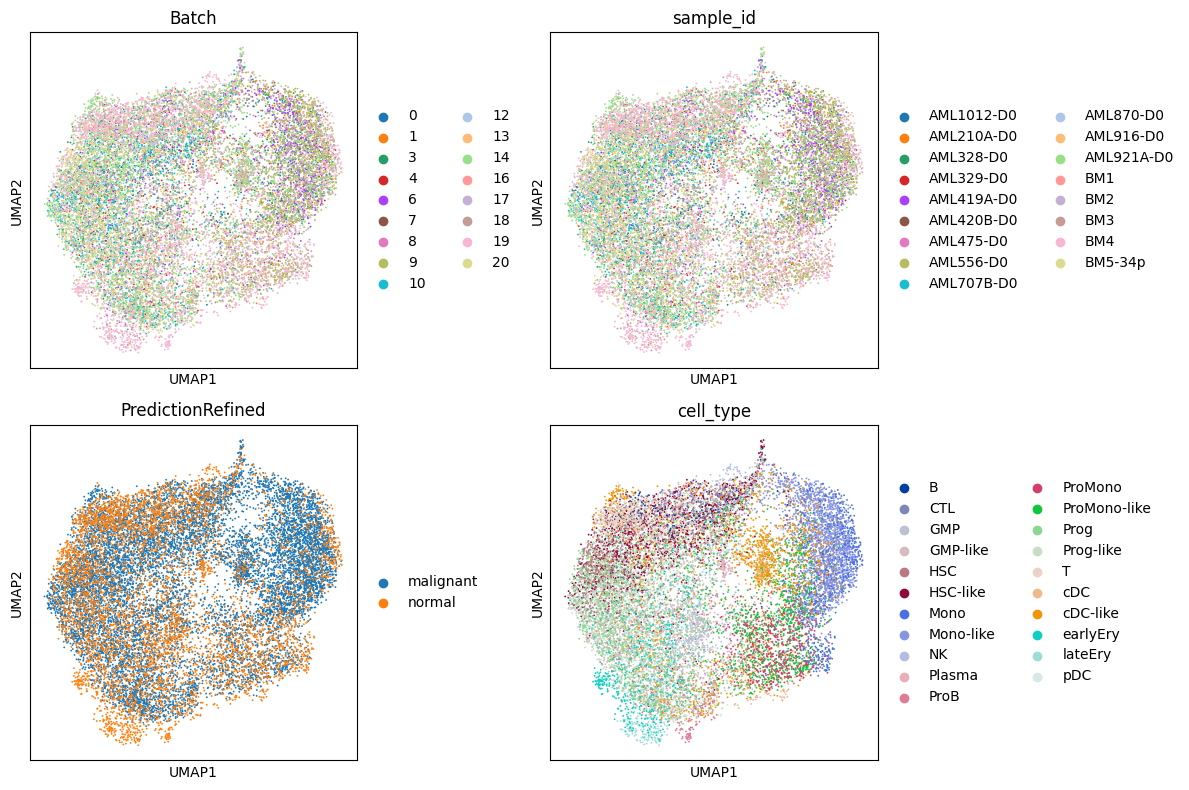

In [25]:
import scanpy as sc
import matplotlib.pyplot as plt

# Calculate neighbors and UMAP on combined_adata
# Note: If BBKNN was run, neighbors might already exist. Check first.
if 'neighbors' not in gears_adata.uns:
    sc.pp.neighbors(gears_adata, n_neighbors=15, use_rep='X_pca_harmony') # Or use existing PCA if available
if 'umap' not in gears_adata.obsm:
    sc.tl.umap(gears_adata)

# Plot UMAP colored by batch and PredictionRefined/sample_type
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sc.pl.umap(gears_adata, color='batch', ax=axes[0][0], show=False, title='Batch')
sc.pl.umap(gears_adata, color='sample_id', ax=axes[0][1], show=False, title='sample_id')
sc.pl.umap(gears_adata, color='PredictionRefined', ax=axes[1][0], show=False, title='PredictionRefined')
sc.pl.umap(gears_adata, color='cell_type', ax=axes[1][1], show=False, title='cell_type')


plt.tight_layout()
plt.show()

# Feature selection

In [39]:
# Use IPython's autoreload magic to automatically reload modules before execution
%load_ext autoreload
%autoreload 2

# Import the module as usual
import feature_selection
from feature_selection import BayesianFeatureSelector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Cell 29 - Instantiate Selector
import time

if combined_adata is not None:
    print("Instantiating BayesianFeatureSelector...")
    # Generate a unique ID for this run, e.g., using a timestamp
    run_id = str(int(time.time()))

    # Instantiate the selector with its required ID and other parameters
    selector = BayesianFeatureSelector(
        unique_id=run_id,
        num_iterations=1000, # Keep original notebook params or adjust
        lr=1e-3,
        credible_interval=0.9,
        num_samples=1000,
        batch_size=256,
        verbose=True, # Set to True for progress
        patience=20,
        max_features=200, # From feature_selection.py, adjust if needed
        use_mlflow=False # Set to True if using MLflow
        # Add other params like k_neighbors if defaults are not desired
    )
    print(f"Selector instantiated with unique_id: {run_id}")

    # Prepare data for fitting: features (X) and target (y)
    expr_df = pd.DataFrame(combined_adata.X,
                           columns=combined_adata.var_names,
                           index=combined_adata.obs_names)

    # Target variable: 'PredictionRefined' mapped to 0/1
    y_series = combined_adata.obs['PredictionRefined'].map({'malignant': 1, 'normal': 0})
    # Ensure y_series index matches expr_df index
    y_series = y_series.reindex(expr_df.index)

    # Check for NaN values introduced by mapping or reindexing
    if y_series.isnull().any():
        print("Warning: NaN values found in target series after mapping/reindexing. Dropping corresponding samples.")
        nan_indices = y_series[y_series.isnull()].index
        expr_df = expr_df.drop(index=nan_indices)
        y_series = y_series.drop(index=nan_indices)
        print(f"Removed {len(nan_indices)} samples with NaN target.")

else:
    print("Skipping Feature Selector instantiation: combined_adata is None.")
    selector = None
    expr_df = None
    y_series = None


Instantiating BayesianFeatureSelector...
Using CUDA (GPU) acceleration.
Selector instantiated with unique_id: 1745841472


In [43]:
if selector is not None and expr_df is not None and y_series is not None:
    print("Fitting BayesianFeatureSelector...")
    start_time = time.time()
    # Fit the selector using the prepared DataFrame and Series
    selector.fit(expr_df, y_series)
    end_time = time.time()
    print(f"Feature selection fitting finished in {end_time - start_time:.2f} seconds.")
else:
    print("Skipping feature selection fitting: selector, expr_df, or y_series is None.")


Fitting BayesianFeatureSelector...


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.69 GiB. GPU 0 has a total capacity of 10.57 GiB of which 2.93 GiB is free. Including non-PyTorch memory, this process has 7.57 GiB memory in use. Of the allocated memory 3.71 GiB is allocated by PyTorch, and 3.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
combined_adata

AnnData object with n_obs × n_vars = 17749 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'sample_type', 'sample_id', 'batch_id_str', 'NanoporeTranscripts', 'batch'
    var: 'gene_name'
    layers: 'counts', 'lognorm'

In [ ]:
if selector is not None and hasattr(selector, 'selected_features_'):
    selected_features = selector.selected_features_
    print(f"Selected {len(selected_features)} features.")
    # Optional: Display the selected feature names
    # print(selected_features)

    # You might also want to access the feature statistics table if generated
    if hasattr(selector, 'feature_stats'):
         feature_stats_df = selector.feature_stats
         print("Feature statistics table generated.")
         # print(feature_stats_df.head())
    if hasattr(selector, 'tail_fig'):
         # Display the figure if desired and not logged to mlflow
         # from IPython.display import display
         # display(selector.tail_fig)
         pass # Figure is available in selector.tail_fig
else:
    print("Skipping feature extraction: selector not fitted or 'selected_features_' attribute missing.")
    selected_features = None
    feature_stats_df = None

Selected 138 features.
Feature statistics table generated.


In [35]:
px.histogram(selector.validation_results_, x='val_accuracy', color='label', log_y=False)

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['iteration', 'train_loss (ELBO)', 'val_loss (NLL)', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'] but received: label

In [42]:
combined_adata

AnnData object with n_obs × n_vars = 17749 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'sample_type', 'sample_id', 'batch_id_str', 'NanoporeTranscripts', 'batch'
    var: 'gene_name'
    layers: 'counts', 'lognorm'

In [ ]:
combined_adata

AnnData object with n_obs × n_vars = 17749 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'sample_type', 'sample_id', 'batch_id_str', 'NanoporeTranscripts', 'batch'
    var: 'gene_name'
    layers: 'counts', 'lognorm'

In [ ]:
combined_adata

AnnData object with n_obs × n_vars = 17749 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'cell_type', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'sample_type', 'sample_id', 'batch_id_str', 'NanoporeTranscripts', 'batch'
    var: 'gene_name'
    layers: 'counts', 'lognorm'

In [30]:
selector.feature_stats

,feature_name,beta_mean,beta_std,effect_size,is_selected
1037,AREG,-1.665568e+00,0.439259,3.791763e+00,True
3441,CFD,1.280196e+00,0.449054,2.850875e+00,True
22012,SELL,-7.500382e-01,0.414672,1.808752e+00,True
5925,EREG,-5.895460e-01,0.443242,1.330078e+00,True
6852,FLT3,4.045619e-01,0.341511,1.184625e+00,True
...,...,...,...,...,...
13584,LOC646522,5.398728e-06,0.371636,1.452692e-05,False
12286,LOC100507389,-3.327734e-06,0.373738,8.903929e-06,False
16254,MIR6834,7.484783e-07,0.372266,2.010600e-06,False
21671,RYK,9.521716e-08,0.371406,2.563695e-07,False


# Generate perturbation conditions

In [38]:
def generate_perturbations(genes_iterable, generate_double_perts=True):
    # Prepare a list of all perturbation conditions
    single_perts = [[gene] for gene in genes_iterable]
    if generate_double_perts:
        double_perts = [(gene1, gene2) for gene1, gene2 in combinations(genes_iterable, 2)]
    else:
        double_perts = []
    all_perts = (single_perts + double_perts)  # Replicate each perturbation three times

    return all_perts

perturbations_wellClassified_features = generate_perturbations(selector.selected_features_, generate_double_perts=False)

In [39]:
perturbations_all_single = generate_perturbations(selector.feature_stats['feature_name'], generate_double_perts=False)

# Initialize pretrained GEARS model & dataloader

In [40]:
gears_data_dir = f"GEARS_data"
os.makedirs(gears_data_dir, exist_ok=True)

In [41]:
# Download pretrained GEARS model (Norman et al. 2019 dataset)
dataverse_download('https://dataverse.harvard.edu/api/access/datafile/10457098', f'{gears_data_dir}/model.zip')

# Extract and set up model directory
with ZipFile(f'{gears_data_dir}/model.zip', 'r') as zip:
    zip.extractall(path = f'{gears_data_dir}/model')
del zip

# Load pretrained model config
pretrainedConfig = pickle.loads(open(f'{gears_data_dir}/model/model_ckpt/config.pkl', 'rb').read())
pretrainedConfig

Found local copy...


{'hidden_size': 64,
 'num_go_gnn_layers': 1,
 'num_gene_gnn_layers': 1,
 'decoder_hidden_size': 16,
 'num_similar_genes_go_graph': 20,
 'num_similar_genes_co_express_graph': 20,
 'coexpress_threshold': 0.4,
 'uncertainty': False,
 'uncertainty_reg': 1,
 'direction_lambda': 0.1,
 'G_go': tensor([[   0,    0,    0,  ..., 9649, 9669, 9693],
         [   0,  126,  514,  ..., 9649, 9669, 9693]]),
 'G_go_weight': tensor([1.0000, 0.1739, 0.1600,  ..., 1.0000, 1.0000, 1.0000]),
 'G_coexpress': tensor([[   0,    1,    2,  ..., 5050, 5052, 5053],
         [   0,    1,    2,  ..., 5050, 5052, 5053]]),
 'G_coexpress_weight': tensor([1.0000, 0.9998, 0.9998,  ..., 1.0000, 1.0000, 1.0000]),
 'device': 'cuda:6',
 'num_genes': 5054,
 'num_perts': 9853,
 'no_perturb': False}

In [42]:
# GEARS does not define the nonzero gene idx for unperturbed test data, so we need to do it manually

def adata_define_nonzero_gene_idx(adata):
    import scipy.sparse as sp
    # Use scipy.sparse.find to get non-zero entries (rows, cols, values)
    _, non_zero_cols, _ = sp.find(adata.X)
    # Get unique columns with non-zero entries
    unique_non_zero_cols = np.unique(non_zero_cols)
    # Map these indices to gene names
    non_zeros_gene_idx = {adata.var_names[idx]: idx for idx in unique_non_zero_cols}
    # Store the result
    adata.uns['non_zeros_gene_idx'] = non_zeros_gene_idx

In [43]:
gears_pertdata = PertData(f'{gears_data_dir}/aml_scrna_embeddings')
gears_adata.X = csr_matrix(gears_adata.X)
adata_define_nonzero_gene_idx(gears_adata)

# set the nonperturbation condition to all cells
gears_adata.obs['condition'] = 'ctrl'
# Convert condition boolean mask to numpy array
gears_adata.obs['condition'] = gears_adata.obs['condition'].astype('str')

gears_pertdata.new_data_process(dataset_name='aml_scrna_embeddings', adata=gears_adata, skip_calc_de=True)
gears_pertdata.prepare_split(split='no_split')

gears_pertdata.dataloader = gears_pertdata.get_dataloader(batch_size=1)


Found local copy...


Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]
Done!
Saving new dataset pyg object at GEARS_data/aml_scrna_embeddings/aml_scrna_embeddings/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1


In [44]:
def GEARS_patched_init_(self, pert_data, 
                 device = 'cuda',
                 weight_bias_track = False, 
                 proj_name = 'GEARS', 
                 exp_name = 'GEARS'):
        """
        Initialize GEARS model

        Parameters
        ----------
        pert_data: PertData object
            dataloader for perturbation data
        device: str
            Device to run the model on. Default: 'cuda'
        weight_bias_track: bool
            Whether to track performance on wandb. Default: False
        proj_name: str
            Project name for wandb. Default: 'GEARS'
        exp_name: str
            Experiment name for wandb. Default: 'GEARS'

        Returns
        -------
        None

        """
        import torch
        self.weight_bias_track = weight_bias_track
        
        if self.weight_bias_track:
            import wandb
            wandb.init(project=proj_name, name=exp_name)  
            self.wandb = wandb
        else:
            self.wandb = None
        
        self.device = device
        self.config = None
        
        self.dataloader = pert_data.dataloader
        self.adata = pert_data.adata
        self.node_map = pert_data.node_map
        self.node_map_pert = pert_data.node_map_pert
        self.data_path = pert_data.data_path
        self.dataset_name = pert_data.dataset_name
        self.split = pert_data.split
        self.seed = pert_data.seed
        self.train_gene_set_size = pert_data.train_gene_set_size
        self.set2conditions = pert_data.set2conditions
        self.subgroup = pert_data.subgroup
        self.gene_list = pert_data.gene_names.values.tolist()
        self.pert_list = pert_data.pert_names.tolist()
        self.num_genes = len(self.gene_list)
        self.num_perts = len(self.pert_list)
        self.default_pert_graph = pert_data.default_pert_graph
        self.saved_pred = {}
        self.saved_logvar_sum = {}
        
        ctrl_mask = (self.adata.obs.condition == 'ctrl').to_numpy()
        self._ctrl_expression = torch.tensor(  # Assign to a regular attribute
                np.mean(self.adata.X[ctrl_mask], axis=0)
            ).reshape(-1,).to(self.device)
        pert_full_id2pert = dict(self.adata.obs[['condition_name', 'condition']].values)
        self.dict_filter = {pert_full_id2pert[i]: j for i, j in
                            self.adata.uns['non_zeros_gene_idx'].items() if
                            i in pert_full_id2pert}
        self.ctrl_adata = self.adata[self.adata.obs['condition'] == 'ctrl']
        
        gene_dict = {g:i for i,g in enumerate(self.gene_list)}
        self.pert2gene = {p: gene_dict[pert] for p, pert in
                          enumerate(self.pert_list) if pert in self.gene_list}

In [45]:
from gears import GEARS
import torch

def check_available_perturbations(gears_wrapper, perturbations_to_predict):
    """
    Check which genes from perturbations_to_predict are available in GEARS pert list.
    
    Args:
        gears_wrapper: GEARS model instance
        perturbations_to_predict: List of perturbations to check
    
    Returns:
        tuple: (available_perts, unavailable_perts)
    """
    available_perts = []
    unavailable_perts = []
    
    # Flatten the perturbations list and get unique genes
    all_genes = set()
    for pert in perturbations_to_predict:
        if isinstance(pert, (list, tuple)):
            all_genes.update(pert)
        else:
            all_genes.add(pert)
    
    # Check each gene
    for gene in all_genes:
        if gene in gears_wrapper.pert_list:
            available_perts.append(gene)
        else:
            unavailable_perts.append(gene)
    
    print(f"\nGene Availability Check:")
    print(f"Available genes: {len(available_perts)}/{len(all_genes)}")
    print("\nAvailable genes:")
    print(available_perts)
    print("\nUnavailable genes:")
    print(unavailable_perts)
    
    return available_perts, unavailable_perts


def run_inference(aml_data, perturbations_to_predict):
    """
    Run GEARS inference using existing batch size configuration.
    
    Args:
        aml_data: Prepared PertData object with existing batch_size
        perturbations_to_predict: List of perturbations to predict
    """
    from scipy.stats import pearsonr, spearmanr
    from types import MethodType
    
    n_cells = len(aml_data.adata)
    batch_size = aml_data.dataloader['test_loader'].batch_size
    print(f"Running predictions for {n_cells} cells using batch_size={batch_size}")

    # Define the ctrl_expression property to return the attribute
    def ctrl_expression_property(self):
        return self._ctrl_expression

    GEARS.ctrl_expression = property(ctrl_expression_property)

    # Monkey patch the __init__ method
    GEARS.__init__ = GEARS_patched_init_

    # Load model for inference
    gears_wrapper = GEARS(
        aml_data,
        device='cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu',
        weight_bias_track=False
    )
    gears_wrapper.load_pretrained(f'{gears_data_dir}/model/model_ckpt')
    gears_wrapper.model.eval()

    # Check available perturbations before running predictions
    available_perts, unavailable_perts = check_available_perturbations(gears_wrapper, perturbations_to_predict)
    
    # Filter perturbations to only include available ones
    filtered_perturbations = [pert for pert in perturbations_to_predict 
                            if all(gene in available_perts for gene in (pert if isinstance(pert, (list, tuple)) else [pert]))]
    
    if not filtered_perturbations:
        raise ValueError("No valid perturbations available for prediction!")
    
    print(f"\nProceeding with {len(filtered_perturbations)} valid perturbations")
    
    # Get cell IDs and original expression
    cell_ids = aml_data.adata.obs_names
    original_expression = aml_data.adata.X.toarray() if issparse(aml_data.adata.X) else aml_data.adata.X
    
    predictions = {}
    with torch.no_grad():
        # Process baseline (no perturbation) in batches
        baseline_preds = []
        for i in tqdm(range(0, n_cells, batch_size), desc="Baseline predictions"):
            batch_end = min(i + batch_size, n_cells)
            batch_size_actual = batch_end - i
            batch_preds = gears_wrapper.predict([[] for _ in range(batch_size_actual)])
            baseline_preds.append(batch_preds[''])  # no perturbation is empty string
        
        predictions['no_perturbation'] = baseline_preds
        
        # Calculate baseline metrics for each cell
        baseline_metrics = pd.DataFrame(index=cell_ids)
        baseline_metrics['mse'] = np.mean((original_expression - baseline_preds) ** 2, axis=1)
        baseline_metrics['pearson'] = [
            pearsonr(original_expression[i], baseline_preds[i])[0] 
            for i in range(n_cells)
        ]
        baseline_metrics['spearman'] = [
            spearmanr(original_expression[i], baseline_preds[i])[0]
            for i in range(n_cells)
        ]
    
    predictions_df = None
    
    print("\nBaseline Prediction Performance:")
    print(f"Mean MSE: {baseline_metrics['mse'].mean():.4f} (±{baseline_metrics['mse'].std():.4f})")
    print(f"Mean Pearson: {baseline_metrics['pearson'].mean():.4f} (±{baseline_metrics['pearson'].std():.4f})")
    print(f"Mean Spearman: {baseline_metrics['spearman'].mean():.4f} (±{baseline_metrics['spearman'].std():.4f})")
    
    # Add percentile rankings
    for metric in ['mse', 'pearson', 'spearman']:
        baseline_metrics[f'{metric}_percentile'] = baseline_metrics[metric].rank(pct=True)
    
    return predictions_df, baseline_metrics, filtered_perturbations, gears_wrapper

predictions_df, baseline_metrics, filtered_perturbations, gears_wrapper = run_inference(gears_pertdata, perturbations_all_single)

# Find cells with best/worst predictions
best_predicted = baseline_metrics.nsmallest(5, 'mse')
worst_predicted = baseline_metrics.nlargest(5, 'mse')

# Analyze cells with different baseline prediction quality
good_cells = baseline_metrics[baseline_metrics['mse_percentile'] < 0.1].index
poor_cells = baseline_metrics[baseline_metrics['mse_percentile'] > 0.9].index

Running predictions for 17749 cells using batch_size=1

Gene Availability Check:
Available genes: 9716/27899

Available genes:
['CEP44', 'LIMS1', 'PAAF1', 'HIST1H2BB', 'MCOLN1', 'VAX1', 'CNDP2', 'HIRIP3', 'RPS4X', 'RPL6', 'PSAT1', 'VILL', 'SUPV3L1', 'GRID2', 'CLCN7', 'TINF2', 'XAGE1B', 'VAMP2', 'KIF4A', 'RNF2', 'CDV3', 'CDK11B', 'LRIG2', 'C2orf88', 'CNOT3', 'SLC7A6OS', 'PIGK', 'HIST1H4E', 'C2orf76', 'CLASP1', 'VMP1', 'DNAJC8', 'FANCD2', 'GIT1', 'KCTD3', 'GALNT10', 'KLF10', 'CCDC125', 'FAM72D', 'EXOC2', 'HSD17B8', 'MSRB1', 'VTI1A', 'MON1A', 'PDS5A', 'ESPL1', 'LCN10', 'RFLNB', 'PDSS2', 'NXT1', 'ATF7IP2', 'QARS', 'ZEB2', 'ISY1', 'RFXANK', 'PDE6D', 'TOP2A', 'BRI3', 'FUT10', 'PRR3', 'ZNF365', 'LRRC47', 'PPP2R3C', 'CRYAB', 'DBN1', 'GDI1', 'PRTFDC1', 'CCNY', 'CCT4', 'IARS', 'NFATC3', 'TMEM242', 'LHX5', 'RER1', 'INO80C', 'MRPL41', 'KAT2B', 'PHKG2', 'NKX1-2', 'TANK', 'HNRNPU', 'SAMHD1', 'ACACA', 'TMEM150A', 'RNF181', 'ZNRF2', 'WDR13', 'PPP2R1B', 'C18orf25', 'DCLRE1A', 'MTMR14', 'LAPTM5', 'RNFT1

Baseline predictions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17749/17749 [06:07<00:00, 48.36it/s]



Baseline Prediction Performance:
Mean MSE: 0.0647 (±0.0189)
Mean Pearson: 0.7425 (±0.0873)
Mean Spearman: 0.4268 (±0.0761)


In [47]:
# Get the metrics for good cells
good_cells_metrics = baseline_metrics.loc[good_cells]

# Find the worst performing cell among good cells (highest MSE)
worst_of_good = good_cells_metrics.nlargest(1, 'mse')

print("Metrics for worst-performing cell among good cells:")
print(f"Cell ID: {worst_of_good.index[0]}")
print(f"MSE: {worst_of_good['mse'].iloc[0]:.6f}")
print(f"Pearson correlation: {worst_of_good['pearson'].iloc[0]:.6f}")
print(f"Spearman correlation: {worst_of_good['spearman'].iloc[0]:.6f}")
print(f"MSE percentile (overall): {worst_of_good['mse_percentile'].iloc[0]:.6f}")

Metrics for worst-performing cell among good cells:
Cell ID: AML556-D0_TTATAACCTCTA
MSE: 0.041632
Pearson correlation: 0.790039
Spearman correlation: 0.571485
MSE percentile (overall): 0.099949


In [48]:
best_of_good = good_cells_metrics.nsmallest(1, 'mse')

print("Metrics for best-performing cell among good cells:")
print(f"Cell ID: {best_of_good.index[0]}")
print(f"MSE: {best_of_good['mse'].iloc[0]:.6f}")
print(f"Pearson correlation: {best_of_good['pearson'].iloc[0]:.6f}")
print(f"Spearman correlation: {best_of_good['spearman'].iloc[0]:.6f}")
print(f"MSE percentile (overall): {best_of_good['mse_percentile'].iloc[0]:.6f}")

Metrics for best-performing cell among good cells:
Cell ID: AML1012-D0_GAAAACCTGTTN
MSE: 0.016101
Pearson correlation: 0.917754
Spearman correlation: 0.654179
MSE percentile (overall): 0.000056


In [57]:
len(good_cells)

1774

In [50]:
good_cells

Index(['AML1012-D0_AAAACACCAATC', 'AML1012-D0_AAACGCTGGAAN',
       'AML1012-D0_AAACTTGCCCGT', 'AML1012-D0_AACATTTAACAT',
       'AML1012-D0_AAGAAGGTATCT', 'AML1012-D0_AAGAGCCACTTC',
       'AML1012-D0_AAGCCATTTTCC', 'AML1012-D0_AAGGTTTTTGAA',
       'AML1012-D0_AAGTGCACCAAT', 'AML1012-D0_AAGTTTTGTTTT',
       ...
       'BM5-34p_GGCGAGGCGAGT', 'BM5-34p_GGGATGACAATA', 'BM5-34p_TATGGGAACCGC',
       'BM5-34p_TCACTTGATTAC', 'BM5-34p_TGATGGCAGACC', 'BM5-34p_TTCACCAGGACG',
       'BM5-34p_TTTCATTATAGC', 'BM5-34p_ACGGTTACTCAT', 'BM5-34p_CACATTTTAGAA',
       'BM5-34p_GACCCCCCGTGA'],
      dtype='object', name='Cell', length=1774)

In [51]:
gears_adata.obs

,NumberOfReads,AlignedToGenome,AlignedToTranscriptome,TranscriptomeUMIs,NumberOfGenes,CyclingScore,CyclingBinary,MutTranscripts,WtTranscripts,PredictionRF2,...,Score_NK,sample_type,sample_id,batch_id_str,NanoporeTranscripts,batch,condition,dose_val,control,condition_name
Cell,,,,,,,,,,,,,,,,,,,,,
AML1012-D0_AAAACACCAATC,85496,63659,43073,4810,1713,-0.484,no,NaN,NaN,malignant,...,0.052,case,AML1012-D0,0,NaN,0,ctrl,1,1,GMP-like_ctrl_1
AML1012-D0_AAAATAGCCTTT,35481,28600,17200,2305,853,-0.557,no,NaN,NaN,malignant,...,0.026,case,AML1012-D0,0,NaN,0,ctrl,1,1,Prog-like_ctrl_1
AML1012-D0_AAACATTAAACG,39408,29874,23273,2266,976,-0.581,no,NaN,NaN,normal,...,0.019,case,AML1012-D0,0,NaN,0,ctrl,1,1,ProMono-like_ctrl_1
AML1012-D0_AAACCACGTGCN,22632,17136,12459,1561,744,-0.222,no,NaN,NaN,malignant,...,0.056,case,AML1012-D0,0,NaN,0,ctrl,1,1,Prog-like_ctrl_1
AML1012-D0_AAACGCTGGAAN,67767,51466,37700,3572,1416,0.527,yes,NaN,NaN,malignant,...,0.026,case,AML1012-D0,0,NaN,0,ctrl,1,1,GMP-like_ctrl_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BM5-34p_GAAAACAAAACG,19160,15672,10749,1694,793,-0.082,no,NaN,NaN,normal,...,0.017,healthy,BM5-34p,20,NaN,20,ctrl,1,1,GMP_ctrl_1
BM5-34p_TTAAACAAAATG,23385,19181,15245,2511,876,-0.375,no,NaN,NaN,normal,...,0.008,healthy,BM5-34p,20,NaN,20,ctrl,1,1,HSC_ctrl_1
BM5-34p_TCTCACGGACAG,19815,16598,12020,2364,1083,1.548,yes,NaN,NaN,normal,...,0.012,healthy,BM5-34p,20,NaN,20,ctrl,1,1,ProB_ctrl_1


# Perturbation

In [52]:
def reinit_gears(self):
        """Reinitialize the GEARS model"""
        # Define the ctrl_expression property to return the attribute
        def ctrl_expression_property(self):
            return self._ctrl_expression

        GEARS.ctrl_expression = property(ctrl_expression_property)

        def GEARS_patched_init_(self, pert_data, 
                 device = 'cuda',
                 weight_bias_track = False, 
                 proj_name = 'GEARS', 
                 exp_name = 'GEARS'):
            """
            Initialize GEARS model

            Parameters
            ----------
            pert_data: PertData object
                dataloader for perturbation data
            device: str
                Device to run the model on. Default: 'cuda'
            weight_bias_track: bool
                Whether to track performance on wandb. Default: False
            proj_name: str
                Project name for wandb. Default: 'GEARS'
            exp_name: str
                Experiment name for wandb. Default: 'GEARS'

            Returns
            -------
            None

            """
            import torch
            self.weight_bias_track = weight_bias_track
            
            if self.weight_bias_track:
                import wandb
                wandb.init(project=proj_name, name=exp_name)  
                self.wandb = wandb
            else:
                self.wandb = None
            
            self.device = device
            self.config = None
            
            self.dataloader = pert_data.dataloader
            self.adata = pert_data.adata
            self.node_map = pert_data.node_map
            self.node_map_pert = pert_data.node_map_pert
            self.data_path = pert_data.data_path
            self.dataset_name = pert_data.dataset_name
            self.split = pert_data.split
            self.seed = pert_data.seed
            self.train_gene_set_size = pert_data.train_gene_set_size
            self.set2conditions = pert_data.set2conditions
            self.subgroup = pert_data.subgroup
            self.gene_list = pert_data.gene_names.values.tolist()
            self.pert_list = pert_data.pert_names.tolist()
            self.num_genes = len(self.gene_list)
            self.num_perts = len(self.pert_list)
            self.default_pert_graph = pert_data.default_pert_graph
            self.saved_pred = {}
            self.saved_logvar_sum = {}
            
            ctrl_mask = (self.adata.obs.condition == 'ctrl').to_numpy()
            self._ctrl_expression = torch.tensor(  # Assign to a regular attribute
                    np.mean(self.adata.X[ctrl_mask], axis=0)
                ).reshape(-1,).to(self.device)
            pert_full_id2pert = dict(self.adata.obs[['condition_name', 'condition']].values)
            self.dict_filter = {pert_full_id2pert[i]: j for i, j in
                                self.adata.uns['non_zeros_gene_idx'].items() if
                                i in pert_full_id2pert}
            self.ctrl_adata = self.adata[self.adata.obs['condition'] == 'ctrl']
            
            gene_dict = {g:i for i,g in enumerate(self.gene_list)}
            self.pert2gene = {p: gene_dict[pert] for p, pert in
                            enumerate(self.pert_list) if pert in self.gene_list}

        # Monkey patch the __init__ method
        GEARS.__init__ = GEARS_patched_init_

        # Load model for inference
        gears_wrapper = GEARS(
            self.original_pert_data,
            device='cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu',
            weight_bias_track=False
        )
        gears_wrapper.load_pretrained(self.gears_data_dir)
        gears_wrapper.model.eval()

        torch.cuda.empty_cache()
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()

        return gears_wrapper

In [53]:
# Load the autoreload extension to automatically reload modules
%load_ext autoreload
# Configure autoreload to reload all modules before executing code (if changed)
%autoreload 2

import torch
import GEARS.perturbation_evaluator as perturbation_evaluator
import importlib


# Get the list of genes from the filtered AnnData.
genes = gears_adata.var_names

# Create a mapping from gene name to index based on aml_data.adata.
gene_to_index = {gene: i for i, gene in enumerate(gears_pertdata.adata.var_names)}

# Now, for each upregulated gene, get its index from aml_data.adata.
gene_subset = [gene_to_index[gene] for gene in genes if gene in gene_to_index]

print(f"Found indices for {len(gene_subset)} genes out of {len(genes)} genes.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found indices for 5054 genes out of 5054 genes.


In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract cell states for all these good cells.
sorted_adata = gears_pertdata.adata[good_cells].copy()

# Convert sorted_adata to a dense array so that cells can be sorted by their overall expression.
if issparse(sorted_adata.X):
    X_array = sorted_adata.X.toarray()
else:
    X_array = sorted_adata.X

# Sort the cells by total expression (row sum)
X_tensor = torch.tensor(X_array)
_, sort_idx = torch.sort(X_tensor.sum(dim=1), descending=False)

# Reorder the cells by sorted indices
sorted_adata = sorted_adata[sort_idx.numpy()]

# Separate the good cells into normal and malignant subsets based on 'PredictionRefined'
healthy_adata = sorted_adata[sorted_adata.obs['PredictionRefined'] == 'normal']
cancer_adata = sorted_adata[sorted_adata.obs['PredictionRefined'] == 'malignant']

In [55]:
healthy_adata.obs.groupby('sample_id').size()

sample_id
BM1          1
BM3        112
BM4         70
BM5-34p    239
dtype: int64

In [58]:
cancer_adata.obs.groupby('sample_id').size()

sample_id
AML1012-D0    231
AML210A-D0     28
AML328-D0      95
AML329-D0      42
AML419A-D0     24
AML420B-D0     55
AML475-D0      11
AML556-D0      80
AML707B-D0     99
AML870-D0      34
AML916-D0     131
AML921A-D0    522
dtype: int64

In [99]:
import pickle
import pandas as pd
from datetime import datetime

def save_evaluation_results(evaluation_results, filename_prefix="evaluation_results", save_pickle=False):
    """
    Save evaluation results to CSV (and optionally as a pickle file).

    Parameters
    ----------
    evaluation_results : list
        A list of evaluation result objects. Each result should have at least the following:
            - result.perturbation : an object (converted to a string for saving)
            - result.scores : a dict with keys:
                   'baseline_classifier', 'classifier', 'wasserstein', 'stability', 'density', 'total'
    filename_prefix : str, optional
        Prefix for the output filenames (default: "evaluation_results").
    save_pickle : bool, optional
        Whether to also save the raw evaluation results as a pickle file (default: False).

    Returns
    -------
    tuple:
        csv_filename (str): Filename of the saved CSV file.
        pickle_filename (str or None): Filename of the saved pickle file if save_pickle is True; otherwise, None.
    """
    # Create a timestamp that will be appended to the filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Prepare a list of dictionaries from the results
    results_list = []
    for result in evaluation_results:
        result_dict = {
            'perturbation': str(result.perturbation),
            'baseline_classifier': result.scores.get('baseline_classifier', None),
            'classifier_score': result.scores.get('classifier', None),
            'wasserstein': result.scores.get('wasserstein', None),
            'stability': result.scores.get('stability', None),
            'density': result.scores.get('density', None),
            'total_score': result.scores.get('total', None)
        }
        results_list.append(result_dict)

    # Convert the list to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Save the DataFrame to a CSV file
    csv_filename = f"{filename_prefix}_{timestamp}.csv"
    results_df.to_csv(csv_filename, index=False)

    # Optionally, also save the raw evaluation results as a pickle file
    pickle_filename = None
    if save_pickle:
        pickle_filename = f"{filename_prefix}_{timestamp}.pkl"
        with open(pickle_filename, "wb") as f:
            pickle.dump(evaluation_results, f)

    # Report the saved filenames
    print("Results saved to:")
    if save_pickle:
        print(f"1. {pickle_filename}")
        print(f"2. {csv_filename}")
    else:
        print(csv_filename)

    return csv_filename, pickle_filename

In [100]:
def extract_perturbations_by_classifier_change(evaluation_results, scenario="healthy_to_aml"):
    """
    Extract perturbations from evaluation results based on the change in classifier score relative to baseline.
    
    This version expects evaluation_results to be a pandas DataFrame (for example, loaded from the CSV file).
    
    Parameters
    ----------
    evaluation_results : pd.DataFrame
        A DataFrame of evaluation results with at least the following columns:
            - 'perturbation'
            - 'baseline_classifier'
            - 'classifier'
    scenario : str, optional
        The scenario to use for selecting perturbations. Options are:
          - "healthy_to_aml": Select perturbations that increase the classifier score over the baseline
                              (i.e. push healthy cells into an AML-like state).
          - "aml_to_healthy": Select perturbations that decrease the classifier score below the baseline
                              (i.e. push AML cells toward a healthy state).
    
    Returns
    -------
    selected_perturbations : list
        A list of perturbation identifiers (as they were saved in the CSV) that satisfy the condition.
    """
    import pandas as pd

    if scenario not in ["healthy_to_aml", "aml_to_healthy"]:
        raise ValueError("Scenario must be one of 'healthy_to_aml' or 'aml_to_healthy'.")

    selected_perturbations = []
    for idx, row in evaluation_results.iterrows():
        baseline = row.get('baseline_classifier')
        new_score = row.get('classifier')
        # Skip if we cannot find either score (or if they're NaN)
        if pd.isna(baseline) or pd.isna(new_score):
            continue

        if scenario == "healthy_to_aml" and new_score > 0.5:
            selected_perturbations.append(row['perturbation'])
        elif scenario == "aml_to_healthy" and new_score < 0.5:
            selected_perturbations.append(row['perturbation'])

    return selected_perturbations[:100]

# One-Vs-Rest Feature Selection

In [2]:
# Cell 1: Setup and Imports (No changes needed from the previous plan)
import time
import pandas as pd
import numpy as np
import anndata as ad
from feature_selection import BayesianFeatureSelector
import logging
import torch # Already imported likely
from scipy.sparse import issparse # Already imported likely

# --- Configuration ---
SELECTOR_PARAMS = {
    'num_iterations': 1000, 'lr': 1e-3, 'credible_interval': 0.9,
    'num_samples': 1000, 'batch_size': 256, 'verbose': False,
    'patience': 20, 'max_features': 200, 'k_neighbors': 10,
    'smooth_window': 1, 'base_cumulative_density_threshold': 0.005,
    'base_sensitivity': 0.005, 'use_mlflow': False
}
CASE_TYPE_LABEL = 'case' # Adjust if your label for cases is different
CONTROL_TYPE_LABEL = 'healthy' # Adjust if your label for controls is different

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Ensure device is set (likely done already)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f"Using device: {device}") # Log the device being used by PyTorch

print("Setup complete. Configuration loaded.")


/home/noot/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-28 04:21:15,832 - INFO - Using device: cuda


Setup complete. Configuration loaded.


In [3]:
# Cell 2: Prepare Sample Keys and Control Data Indices
# Now operates on 'adata' which points to the pre-processed 'sorted_adata'
if 'sorted_adata' in locals():
    logger.info("Preparing sample keys and control indices from the provided adata...")

    # Extract unique sample prefixes from the index
    # Ensure this logic matches your index format (e.g., delimiter is '_')
    try:
        sorted_adata.obs['sample_prefix'] = sorted_adata.obs.index.str.split('_').str[0]
    except Exception as e:
        logger.error(f"Failed to extract 'sample_prefix' from index. Check index format. Error: {e}")
        raise

    unique_prefixes = sorted_adata.obs['sample_prefix'].unique()

    # Map prefixes to sample types using the 'sample_type' column
    # Assumes 'sample_type' column exists (checked in the previous bridge cell)
    prefix_to_type = sorted_adata.obs.groupby('sample_prefix')['sample_type'].first()

    # Identify case and control keys based on specified labels
    all_keys = prefix_to_type.index
    case_keys = all_keys[prefix_to_type == CASE_TYPE_LABEL].tolist()
    control_keys = all_keys[prefix_to_type == CONTROL_TYPE_LABEL].tolist()

    logger.info(f"Found {len(case_keys)} case keys: {case_keys}")
    logger.info(f"Found {len(control_keys)} control keys: {control_keys}")

    if not control_keys:
        logger.warning("No control keys found. OvR requires control samples.")
        control_indices = pd.Index([])
    elif not case_keys:
        logger.warning("No case keys found. OvR requires case samples.")
        control_indices = sorted_adata.obs.index[sorted_adata.obs['sample_prefix'].isin(control_keys)] # Still useful perhaps
    else:
        # Get indices for all control cells (do this once)
        control_indices = sorted_adata.obs.index[sorted_adata.obs['sample_prefix'].isin(control_keys)]
        logger.info(f"Found {len(control_indices)} total cells belonging to control samples.")

    # Optional: Clean up temporary column if not needed later
    # del adata.obs['sample_prefix']

else:
    logger.warning("Skipping key preparation: 'adata' object not found.")
    case_keys = []
    control_keys = []
    control_indices = pd.Index([])


2025-04-28 04:21:17,421 - WARNING - Skipping key preparation: 'adata' object not found.


In [4]:
# Cell 3: Run One-vs-Rest Feature Selection Loop
# Uses the 'adata' object (our sorted_adata) and the keys/indices prepared above.
if 'sorted_adata' in locals() and case_keys and not control_indices.empty:
    logger.info("Starting One-vs-Rest feature selection loop...")
    ovr_results = {}
    overall_start_time = time.time()

    for i, case_key in enumerate(case_keys):
        case_start_time = time.time()
        logger.info(f"--- Processing Case {i+1}/{len(case_keys)}: {case_key} ---")

        # 1. Get positive indices for the current case
        # Use the 'sample_prefix' column created in the previous cell
        positive_indices = sorted_adata.obs.index[sorted_adata.obs['sample_prefix'] == case_key]
        logger.info(f"Found {len(positive_indices)} cells for case {case_key}.")

        if positive_indices.empty:
            logger.warning(f"Skipping case {case_key}: No cells found.")
            ovr_results[case_key] = {'status': 'skipped_no_positive_cells', 'error': None, 'selector': None}
            continue

        # 2. Combine indices (positive case cells + all control cells)
        combined_indices = positive_indices.union(control_indices)
        logger.info(f"Total cells for this run ({case_key} vs Controls): {len(combined_indices)}")

        # 3. Filter AnnData (creates a view or copy)
        # Using .copy() for safety, especially in loops
        adata_subset = sorted_adata[combined_indices, :].copy()

        # 4. Prepare X and y
        logger.info("Preparing X (features) and y (target)...")
        # Input X should already be dense based on your preprocessing snippet
        if issparse(adata_subset.X):
             # This shouldn't happen if your previous snippet made it dense, but handle defensively
             logger.warning("Sparse matrix found unexpectedly. Converting to dense.")
             X_array = adata_subset.X.toarray()
        else:
             X_array = adata_subset.X # Should be a dense numpy array

        expr_df = pd.DataFrame(X_array,
                               index=adata_subset.obs.index,
                               columns=adata_subset.var_names)

        # Create target variable y: 1 for case, 0 for control
        y_series = pd.Series(0, index=adata_subset.obs.index, dtype=int)
        # Use loc with the positive_indices index object
        y_series.loc[positive_indices] = 1

        # Sanity check counts
        logger.info(f"Target distribution: {y_series.value_counts().to_dict()}")
        if y_series.isnull().any():
             logger.warning(f"NaN values found in target for case {case_key}. This is unexpected.")

        # 5. Instantiate and Fit Selector
        run_id = f"OvR_{case_key}_{int(time.time())}"
        logger.info(f"Instantiating selector with ID: {run_id}")
        # Pass the device to the selector if it uses it internally (it does)
        selector = BayesianFeatureSelector(unique_id=run_id, **SELECTOR_PARAMS) # device is handled internally

        logger.info(f"Fitting selector for case {case_key}...")
        try:
            # Ensure selector uses the correct device (handled in its __init__)
            selector.fit(expr_df, y_series)
            fit_duration = time.time() - case_start_time
            logger.info(f"Fitting for case {case_key} completed in {fit_duration:.2f} seconds.")

            # 6. Store Results
            ovr_results[case_key] = {
                'status': 'success', 'error': None,
                'selected_features': selector.selected_features_.tolist(), # Convert Index/array to list
                'num_selected': len(selector.selected_features_),
                'selection_threshold': selector.selected_credible_interval,
                'feature_stats': selector.feature_stats.copy(), # Store a copy of the DataFrame
                'fit_duration_seconds': fit_duration, 'run_id': run_id,
                'validation_results': getattr(selector, 'validation_results_', None).copy() if hasattr(selector, 'validation_results_') and selector.validation_results_ is not None else None # Store copy if exists
            }
            logger.info(f"Stored results for {case_key}. Selected {len(selector.selected_features_)} features.")

        except Exception as e:
            fit_duration = time.time() - case_start_time
            logger.error(f"Fitting failed for case {case_key} after {fit_duration:.2f} seconds: {e}", exc_info=True) # Use exc_info=True for traceback during debugging
            ovr_results[case_key] = {
                'status': 'failed', 'error': str(e), 'selector': None,
                'fit_duration_seconds': fit_duration, 'run_id': run_id
            }

        # Clean up memory
        del adata_subset, expr_df, y_series, selector, X_array
        import gc
        gc.collect() # More aggressive garbage collection

    overall_duration = time.time() - overall_start_time
    logger.info(f"--- OvR Loop Finished in {overall_duration:.2f} seconds ---")

else:
    logger.warning("Skipping OvR loop: 'sorted_adata' object not found, no case keys identified, or no control cells found.")
    ovr_results = {}


2025-04-28 04:21:18,447 - WARNING - Skipping OvR loop: 'sorted_adata' object not found, no case keys identified, or no control cells found.


In [5]:
ovr_results.keys()

dict_keys([])

In [6]:
ovr_results['AML1012-D0'].keys()

KeyError: 'AML1012-D0'

In [7]:
if ovr_results:
    logger.info("Analyzing One-vs-Rest Results...")

    # Convert results to a DataFrame for easier analysis
    results_list = []
    for case, data in ovr_results.items():
        row = {'case_key': case, **data}
        # Avoid trying to put large objects like DataFrames directly into the summary DF
        row.pop('feature_stats', None)
        row.pop('validation_results', None)
        row.pop('selected_features', None) # Can re-extract later if needed from feature_stats
        results_list.append(row)
    results_df = pd.DataFrame(results_list)

    print("Summary of OvR Runs:")
    print(results_df[['case_key', 'status', 'num_selected', 'selection_threshold', 'fit_duration_seconds', 'error']].to_string()) # Use to_string for better display

    # Example: Aggregate selected features
    all_selected_features = []
    successful_runs = 0
    feature_selection_counts = {}
    for case, data in ovr_results.items():
        if data['status'] == 'success' and 'selected_features' in data:
            successful_runs += 1
            # Ensure selected_features are hashable (e.g., strings)
            current_features = data['selected_features']
            all_selected_features.extend(current_features)
            for feature in current_features:
                 feature_selection_counts[feature] = feature_selection_counts.get(feature, 0) + 1


    if successful_runs > 0:
        print(f"\nAnalysis based on {successful_runs} successful runs:")
        # Top N most frequently selected features
        feature_counts_series = pd.Series(feature_selection_counts).sort_values(ascending=False)
        print("\nTop 20 most frequently selected features across all successful OvR runs:")
        print(feature_counts_series.head(20))

        # Example: Access feature stats for a specific case
        example_case = results_df[results_df['status']=='success']['case_key'].iloc[0]
        print(f"\nFeature statistics for case: {example_case}")
        # Check if stats exist before accessing
        if ovr_results[example_case]['feature_stats'] is not None:
             print(ovr_results[example_case]['feature_stats'].head())
        else:
             print("Feature statistics not available for this case.")

    else:
        print("\nNo successful runs to analyze features from.")

else:
    print("No OvR results available to analyze.")


No OvR results available to analyze.



Visualizing validation metrics for case: AML1012-D0


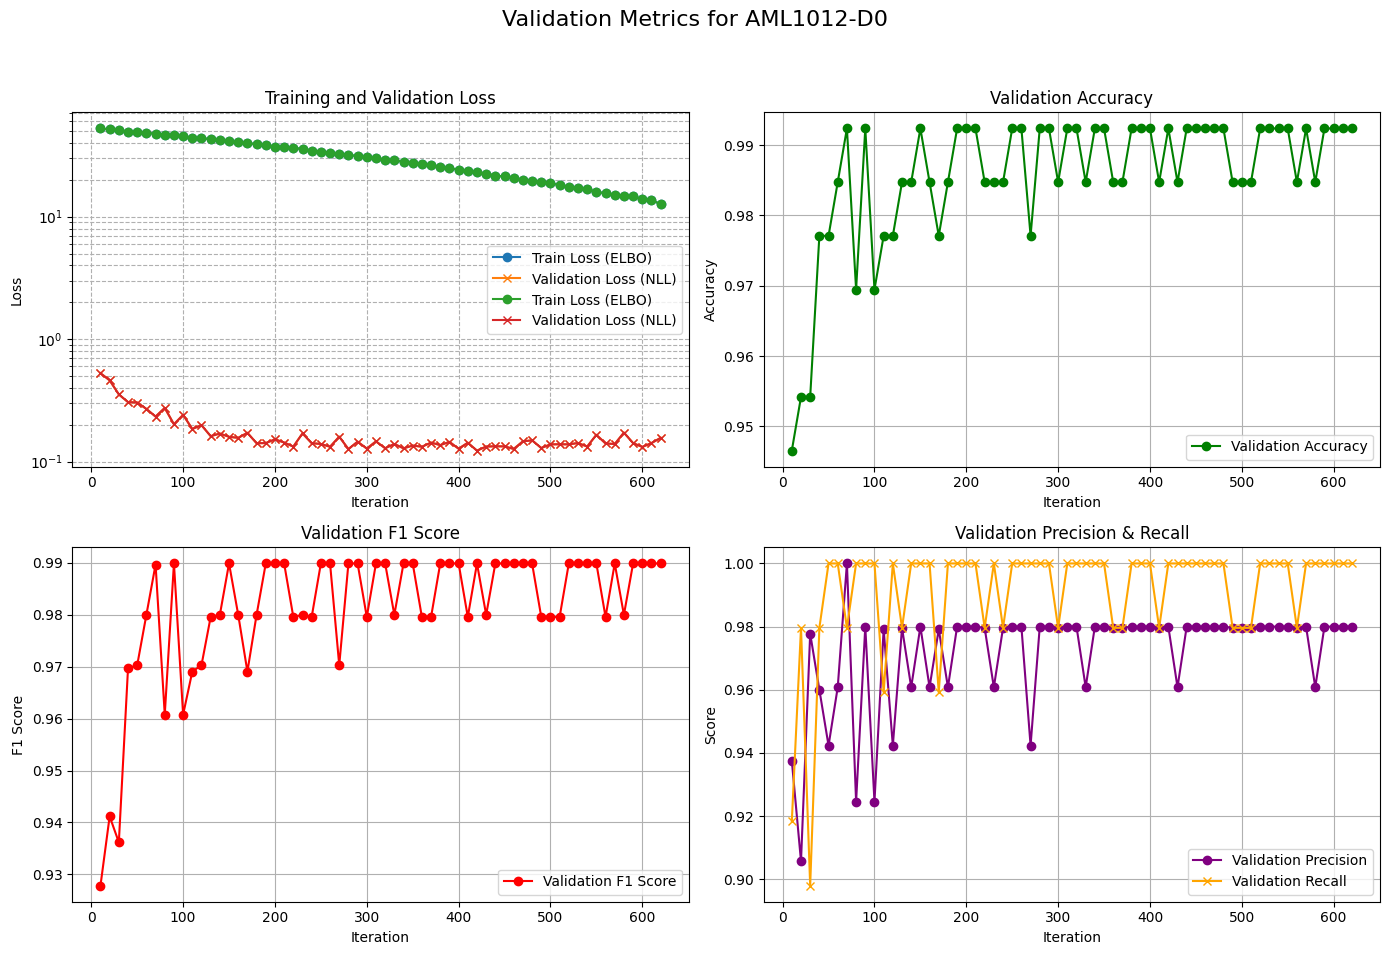

In [91]:
# --- Visualize Validation Metrics ---
import matplotlib.pyplot as plt
import pandas as pd

# Select a case to visualize (make sure this case exists and was successful)
case_to_visualize = 'AML1012-D0' # Example case key

if 'ovr_results' in locals() and ovr_results and case_to_visualize in ovr_results and ovr_results[case_to_visualize]['status'] == 'success':
    validation_data = ovr_results[case_to_visualize].get('validation_results')

    if validation_data:
        # Convert list of dictionaries to DataFrame
        val_df = pd.DataFrame(validation_data)

        if not val_df.empty and 'iteration' in val_df.columns:
            print(f"\nVisualizing validation metrics for case: {case_to_visualize}")

            fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Create a 2x2 grid of plots
            fig.suptitle(f'Validation Metrics for {case_to_visualize}', fontsize=16)

            # Plot 1: Losses
            if 'train_loss (ELBO)' in val_df.columns:
                 axes[0, 0].plot(val_df['iteration'], val_df['train_loss (ELBO)'], label='Train Loss (ELBO)', marker='o')
            if 'val_loss (NLL)' in val_df.columns:
                 axes[0, 0].plot(val_df['iteration'], val_df['val_loss (NLL)'], label='Validation Loss (NLL)', marker='x')

            if plot_loss:
                axes[0, 0].set_xlabel('Iteration')
                axes[0, 0].set_ylabel('Loss (Log Scale)') # Updated label
                axes[0, 0].set_yscale('log') # Use logarithmic scale for the y-axis
                axes[0, 0].set_title('Training and Validation Loss')
                axes[0, 0].legend()
                axes[0, 0].grid(True, which='both', linestyle='--') # Grid for both major and minor ticks on log scale
            else:
                axes[0, 0].set_title('Training and Validation Loss (Not Plotted)')
                axes[0, 0].text(0.5, 0.5, 'Loss data not suitable for log scale or not found', horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)
            
            

            # Plot 2: Accuracy
            if 'val_accuracy' in val_df.columns:
                axes[0, 1].plot(val_df['iteration'], val_df['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
                axes[0, 1].set_xlabel('Iteration')
                axes[0, 1].set_ylabel('Accuracy')
                axes[0, 1].set_title('Validation Accuracy')
                axes[0, 1].legend()
                axes[0, 1].grid(True)
            else:
                 axes[0, 1].set_title('Validation Accuracy (Not Available)')
                 axes[0, 1].text(0.5, 0.5, 'Data not found', horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)


            # Plot 3: F1 Score
            if 'val_f1' in val_df.columns:
                axes[1, 0].plot(val_df['iteration'], val_df['val_f1'], label='Validation F1 Score', marker='o', color='red')
                axes[1, 0].set_xlabel('Iteration')
                axes[1, 0].set_ylabel('F1 Score')
                axes[1, 0].set_title('Validation F1 Score')
                axes[1, 0].legend()
                axes[1, 0].grid(True)
            else:
                 axes[1, 0].set_title('Validation F1 Score (Not Available)')
                 axes[1, 0].text(0.5, 0.5, 'Data not found', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)

            # Plot 4: Precision and Recall (Optional, if present)
            if 'val_precision' in val_df.columns and 'val_recall' in val_df.columns:
                axes[1, 1].plot(val_df['iteration'], val_df['val_precision'], label='Validation Precision', marker='o', color='purple')
                axes[1, 1].plot(val_df['iteration'], val_df['val_recall'], label='Validation Recall', marker='x', color='orange')
                axes[1, 1].set_xlabel('Iteration')
                axes[1, 1].set_ylabel('Score')
                axes[1, 1].set_title('Validation Precision & Recall')
                axes[1, 1].legend()
                axes[1, 1].grid(True)
            else:
                 axes[1, 1].set_title('Validation Precision & Recall (Not Available)')
                 axes[1, 1].text(0.5, 0.5, 'Data not found', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)


            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show()

        else:
            print(f"Validation data for {case_to_visualize} is empty or missing 'iteration' column.")
    else:
        print(f"No 'validation_results' found for case: {case_to_visualize}")
else:
    # Check which condition failed
    if 'ovr_results' not in locals():
        print("Error: 'ovr_results' dictionary not found in the current scope.")
    elif not ovr_results:
         print("Error: 'ovr_results' dictionary is empty.")
    elif case_to_visualize not in ovr_results:
        print(f"Error: Case '{case_to_visualize}' not found in ovr_results keys.")
    elif ovr_results[case_to_visualize]['status'] != 'success':
         print(f"Error: Run for case '{case_to_visualize}' was not successful (status: {ovr_results[case_to_visualize]['status']}).")
    else:
         print(f"Could not visualize: An unknown issue occurred with case '{case_to_visualize}'.")


## healthy -> AML

In [112]:
all_perturbations = generate_perturbations(list(set(gears_wrapper.pert_list) & set(healthy_adata.var.gene_symbol.tolist())), generate_double_perts=False)

In [118]:
def evaluate_perturbations(perturbation_list, scenario="aml_to_healthy", results_filename="healthyToAML"):
    """
    Evaluate perturbations using the generator-based evaluator and immediately write results to CSV.
    
    Parameters:
        perturbation_list (list): List of candidate perturbations.
        scenario (str, optional): Scenario to use.
                                  For example, "aml_to_healthy" means perturb healthy cells toward an AML-like state.
        results_filename (str, optional): Prefix for the CSV file to be written.
    
    Returns:
        csv_filename (str): The name of the CSV file that was written.
    """
    import csv
    from datetime import datetime

    # Determine which AnnData to use as the current (baseline) state.
    current_adata = healthy_adata if scenario == 'aml_to_healthy' else cancer_adata

    evaluator = perturbation_evaluator.PerturbationEvaluator(
        classifier=selector,
        reference_state=cancer_adata if scenario == 'aml_to_healthy' else healthy_adata,
        device=device,
        invert_classifier_score=True if scenario == 'aml_to_healthy' else False,
        gears_data_dir=f"{gears_data_dir}/model",
        gene_subset=gene_subset,
        template_adata=gears_adata
    )
    
    # Use the generator-based evaluation method to process perturbations in chunks.
    results_gen = evaluator.evaluate_perturbations(current_adata, perturbation_list, chunk_size=100)
    
    # Create a CSV filename with an appended timestamp.
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f"{results_filename}_{timestamp}.csv"
    
    # Open the CSV file for writing and write a header.
    with open(csv_filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        header = ["perturbation", "baseline_classifier", "classifier", "wasserstein", "stability", "density", "total"]
        writer.writerow(header)
        
        # Iterate over each result from the generator and write it to the CSV.
        for result in results_gen:
            scores = result.scores
            row = [
                result.perturbation,
                scores.get("baseline_classifier", None),
                scores.get("classifier", None),
                scores.get("wasserstein", None),
                scores.get("stability", None),
                scores.get("density", None),
                scores.get("total", None)
            ]
            writer.writerow(row)
    
    print(f"Results saved to {csv_filename}")
    return csv_filename

In [119]:
evaluation_result_path = evaluate_perturbations(all_perturbations, 
                                                scenario="healthy_to_aml",
                                                results_filename="healthyToAML_allCases_allPerts")

# Load the CSV file containing the evaluation results.
results_df = pd.read_csv(evaluation_result_path)

if not results_df.empty:
    print("Perturbation Evaluation Results:")
    for idx, row in results_df.iterrows():
        print(f"\nPerturbation #{idx+1}:")
        print(f"  Perturbation: {row['perturbation']}")
        print(f"  Baseline Classifier Score: {float(row['baseline_classifier']):.4f}")
        print(f"  Predicted Classifier Score: {float(row['classifier']):.4f}")
        print(f"  Wasserstein Distance: {float(row['wasserstein']):.4f}")
        print(f"  Stability: {float(row['stability']):.4f}")
        print(f"  Density: {float(row['density']):.4f}")
        print(f"  Total Score: {float(row['total']):.4f}")
else:
    print("No valid perturbations found.")

Detected Resources: RAM Available: 28.97 GB, CPU Cores: 16, GPU Available: True, GPU Mem Available: 4.50 GB
Loading GEARS model and preparing PertData...


Downloading...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.46M/9.46M [00:06<00:00, 1.36MiB/s]
Downloading...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559k/559k [00:00<00:00, 611kiB/s]
Creating pyg object for each cell in the data...
Creating dataset file...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data_single_load/single_cell/data_pyg/cell_graphs.pkl
Done!
Creating new splits....
Saving new splits at GEARS_data/mo

GEARS wrapper and model loaded successfully.
Using user-provided chunk_size: 100
Dynamically setting batch_size based on GPU VRAM: 224


ValueError: X has 5054 features, but MinMaxScaler is expecting 27899 features as input.

In [88]:
selected_perturbations = extract_perturbations_by_classifier_change(results_df)
evaluation_results = evaluate_perturbations(generate_perturbations([pert[0] for pert in selected_perturbations], generate_double_perts=True), 
                                            results_filename="healthyToAML_allCases_selectedPerts")
# Print results for each evaluation result in the list.
if evaluation_results:
    print("Perturbation Evaluation Results:")
    for idx, result in enumerate(evaluation_results, start=1):
        print(f"\nPerturbation #{idx}:")
        print(f"  Perturbation: {result.perturbation}")
        print(f"  Baseline Classifier Score: {result.scores['baseline_classifier']:.4f}")
        print(f"  Predicted Classifier Score: {result.scores['classifier']:.4f}")
        print(f"  Wasserstein Distance: {result.scores['wasserstein']:.4f}")
        print(f"  Stability: {result.scores['stability']:.4f}")
        print(f"  Density: {result.scores['density']:.4f}")
        print(f"  Total Score: {result.scores['total']:.4f}")
else:
    print("No valid perturbations found.")

del evaluation_results

Found local copy...
Found local copy...
Creating pyg object for each cell in the data...
Creating dataset file...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]
Done!
Saving new dataset pyg object at GEARS_data/model/pert_data/single_cell/data_pyg/cell_graphs.pkl
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


here1
Processing chunk 1/1 with 6 perturbations...


Chunk 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 937.27it/s]


Results saved to healthyToAML_allCases_selectedPerts_20250423_203955.csv
Perturbation Evaluation Results:

Perturbation #1:


AttributeError: 'str' object has no attribute 'perturbation'

In [89]:
results_df

,perturbation,baseline_classifier,classifier,wasserstein,stability,density,total
0,['TSNAX'],0.13758,0.109087,0.108762,0.850733,0.369330,0.033905
1,['H1FX'],0.13758,0.112938,0.108356,0.850708,0.369271,0.035096
2,['UBE2N'],0.13758,0.109169,0.108661,0.850854,0.369291,0.033932
3,['SRP14'],0.13758,0.110793,0.108599,0.851725,0.369335,0.034476
4,['SDHB'],0.13758,0.112176,0.108896,0.851405,0.369198,0.034879
...,...,...,...,...,...,...,...
3050,['LYRM7'],0.13758,0.113940,0.108828,0.850555,0.369264,0.035399
3051,['DIMT1'],0.13758,0.113782,0.108821,0.850633,0.369193,0.035346
3052,['TMEM259'],0.13758,0.121463,0.108565,0.851972,0.369193,0.037793
3053,['POLDIP2'],0.13758,0.109957,0.108843,0.851229,0.369252,0.034187


### per-individual perturbations

In [35]:
# First, prepare patient-specific datasets and train patient-specific classifiers
patient_specific_classifiers = {}
patient_specific_cancer_adata = {}

# Split cancer data by patient
for i, pid in enumerate(cancer_adata.obs['patient_id'].unique()):
    # Get this patient's AML cells
    patient_adata = cancer_adata[cancer_adata.obs['patient_id'] == pid].copy()
    patient_specific_cancer_adata[pid] = patient_adata
    
    # Create expression dataframe for this patient's cells and all control cells
    patient_expr_df = pd.DataFrame(
        np.vstack([
            patient_adata.X.toarray() if issparse(patient_adata.X) else patient_adata.X,
            healthy_adata.X.toarray() if issparse(healthy_adata.X) else healthy_adata.X
        ]),
        columns=patient_adata.var_names
    )
    
    # Create labels (1 for patient's AML cells, 0 for control cells)
    patient_labels = pd.Series(
        [1] * patient_adata.n_obs + [0] * healthy_adata.n_obs,
        index=range(len(patient_expr_df))
    )
    
    # Train a patient-specific classifier
    print(f"\nTraining classifier for patient {pid}...")
    patient_selector = BayesianFeatureSelector(
        unique_id=hash(pid) % 10000,  # Create a unique ID based on patient ID
        verbose=True,
        lr=0.0001,
        max_features=1000,
        base_sensitivity=0.05,
        base_cumulative_density_threshold=0.05
    )
    patient_selector.fit(patient_expr_df, patient_labels)
    patient_specific_classifiers[pid] = patient_selector

# Now create patient-specific evaluators using the patient-specific classifiers
evaluators_by_patient = {}
for pid, patient_adata in patient_specific_cancer_adata.items():
    evaluator = perturbation_evaluator.PerturbationEvaluator(
        classifier=patient_specific_classifiers[pid],  # Use patient-specific classifier
        reference_state=patient_adata,
        device=device,
        invert_classifier_score=True,
        gears_data_dir=f"{gears_data_dir}/model",
        template_adata=patient_adata
    )
    evaluators_by_patient[pid] = evaluator

print("\nCreated per-patient evaluators with patient-specific classifiers.")

NameError: name 'cancer_adata' is not defined

In [36]:
# Perform perturbation evaluation for each patient using the generator-based evaluation.
# Here, we apply the perturbations to healthy_adata (as our baseline state), letting each evaluator
# compute scores based on how the healthy cells, after perturbation, compare to that patient's AML reference.
evaluation_results_by_patient = {}

for pid, evaluator in evaluators_by_patient.items():
    print(f"\nEvaluating perturbations for patient {pid} ...")
    
    # Evaluate all candidate perturbations, streaming results directly to CSV.
    csv_all = evaluate_perturbations(
        perturbation_list=all_perturbations,
        scenario="aml_to_healthy",
        results_filename=f"{pid}_allPerts"
    )
    
    # Store the CSV filename (or, if desired, load the CSV into a DataFrame).
    evaluation_results_by_patient[pid] = csv_all
    print(f"All-perturbation results for patient {pid} saved to {csv_all}")
    
    # Load the CSV to extract selected perturbations.
    df_all = pd.read_csv(csv_all)
    # Depending on your extract_perturbations_by_classifier_change function,
    # you might need it to work on a DataFrame (one option is to convert the DataFrame rows into a list).
    selected_perturbations = extract_perturbations_by_classifier_change(df_all)
    
    # Generate the list of (double) perturbations for selected ones.
    # (Assuming generate_perturbations accepts a list of perturbations as input.)
    selected_perts = generate_perturbations(
        [pert[0] for pert in selected_perturbations],
        generate_double_perts=True
    )
    
    # Evaluate the selected perturbations using the generator-based method.
    csv_selected = evaluate_perturbations(
        perturbation_list=selected_perts,
        scenario="aml_to_healthy",
        results_filename=f"{pid}_selectedPerts"
    )
    print(f"Selected perturbation results for patient {pid} saved to {csv_selected}")

NameError: name 'evaluators_by_patient' is not defined

In [ ]:
# Summarize the best perturbation (highest composite total score) per patient.
import pandas as pd

summary_records = []
for pid, results in evaluation_results_by_patient.items():
    if results:  # if any valid perturbation evaluation is returned
        best_result = results[0]  # results are sorted in descending order of total score
        summary_records.append({
            'patient_id': pid,
            'best_perturbation': best_result.perturbation,
            'total_score': best_result.scores['total'],
            'classifier_score': best_result.scores['classifier'],
            'wasserstein': best_result.scores['wasserstein'],
            'stability': best_result.scores['stability'],
            'density': best_result.scores['density']
        })

summary_df = pd.DataFrame(summary_records)

print("\nBest perturbations per patient:")
print(summary_df)

## AML -> healthy

In [53]:
len(generate_perturbations(filtered_perturbations))

2850

In [37]:
# Instantiate the evaluator.
# Here, since we perturb healthy cells into an AML state (i.e., higher classifier scores are desirable),
# we set invert_classifier_score=False.
evaluator = perturbation_evaluator.PerturbationEvaluator(
    classifier=selector,
    reference_state=healthy_adata,  # optional: your healthy reference states
    device=device,
    invert_classifier_score=True,
    gears_data_dir=f"{gears_data_dir}/model",
    gene_subset=gene_subset,
    template_adata=patient_adata
)
# Evaluate all the candidate perturbations in a single batched call.
evaluation_results = evaluator.evaluate_perturbations(cancer_adata, generate_perturbations(filtered_perturbations))

# Sort the evaluation results by the total score (highest score first)
evaluation_results.sort(key=lambda x: x.scores['total'], reverse=True)

if evaluation_results:
    best_result = evaluation_results[0]
    print("\nBest Single-Step Perturbation:")
    print(f"Perturbation: {best_result.perturbation}")
    print(f"Baseline Classifier Score: {best_result.scores['baseline_classifier']:.4f}")
    print(f"Classifier Score: {best_result.scores['classifier']:.4f}")
    print(f"Wasserstein Distance: {best_result.scores['wasserstein']:.4f}")
    print(f"Stability: {best_result.scores['stability']:.4f}")
    print(f"Density: {best_result.scores['density']:.4f}")
    print(f"Total Score: {best_result.scores['total']:.4f}")
else:
    print("No valid perturbations found.")

NameError: name 'perturbation_evaluator' is not defined

In [ ]:
del gears_wrapper
gears_wrapper = reinit_gears(aml_data)

In [81]:
good_cells

Index(['AML707B-D0_AACATTACGTTA-0', 'AML707B-D0_AACCGCCAAAGA-0',
       'AML707B-D0_AAGGCCGGTGCA-0', 'AML707B-D0_ACCCGGAGATCC-0',
       'AML707B-D0_ACCGCGGACTCT-0', 'AML707B-D0_ACTGTTTCCCAT-0',
       'AML707B-D0_ACTTAGACACGC-0', 'AML707B-D0_ACTTTCAGCCAN-0',
       'AML707B-D0_AGACGCGGTTCG-0', 'AML707B-D0_AGCGCCCGCACT-0',
       ...
       'BM5-34p_GGCCCCTAGCAG-19', 'BM5-34p_GGCGAGGCGAGT-19',
       'BM5-34p_GGGATGACAATA-19', 'BM5-34p_TATGGGAACCGC-19',
       'BM5-34p_TCACTTGATTAC-19', 'BM5-34p_TGATGGCAGACC-19',
       'BM5-34p_TTCACCAGGACG-19', 'BM5-34p_TTTCATTATAGC-19',
       'BM5-34p_CACATTTTAGAA-19', 'BM5-34p_GACCCCCCGTGA-19'],
      dtype='object', name='Cell', length=1774)

In [82]:
def count_patients_and_cells(good_cells):
    """
    Given a pandas Index of cell IDs (with the first substring before '_' representing the patient ID),
    returns the number of unique patients and a Pandas Series with the number of cells per patient.
    
    Parameters:
        good_cells (pd.Index): Cell IDs
    
    Returns:
        num_patients (int): Number of unique patients
        cells_per_patient (pd.Series): Count of cells per patient
    """
    # Extract the patient ID from each cell id
    patient_ids = [cell.split('_')[0] for cell in good_cells]
    
    # Count cells per patient using value_counts
    cells_per_patient = pd.Series(patient_ids).value_counts()
    
    # Number of unique patients
    num_patients = cells_per_patient.shape[0]
    
    return num_patients, cells_per_patient

num_patients, cells_per_patient = count_patients_and_cells(good_cells)
print(f"Number of unique patients: {num_patients}\n")
print("Cells per patient:")
print(cells_per_patient)

Number of unique patients: 16

Cells per patient:
AML921A-D0    526
BM5-34p       226
AML1012-D0    224
AML707B-D0    119
BM3           107
AML328-D0     103
AML556-D0     101
AML916-D0      97
BM4            86
AML329-D0      51
AML420B-D0     49
AML210A-D0     35
AML870-D0      25
AML419A-D0     17
AML475-D0       7
BM1             1
Name: count, dtype: int64
